# Theory Analysis at given quantile across latitudes
This notebook applies the adiabatic theory for convectively set change in temperature to a range of latitudes.

It is adapted from the [theory breakdown.ipynb](https://github.com/jduffield65/Isca/blob/main/jobs/tau_sweep/land/meridional_band/publish_figures/theory_breakdown.ipynb) notebook used for Isca simulations.

In [6]:
import copy
import sys
import os

import warnings


# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R
from isca_tools.utils import area_weighting
from isca_tools.thesis.adiabat_theory2 import get_scale_factor_theory, get_approx_terms, get_sensitivity_factors, get_cape_approx
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import integrate
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 1.2          # make lines bigger for presentation

In [7]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05
im_sz = 1.5

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

#### Load in Data
Quantile data is obtained from CESM datasets and output into npz files. Here I am just interested in the npz files. For quantile data, the shape of array is `[2, n_lat, n_quant]` where the first index is `0` for land and `1` for ocean coordinates (quantiles are found separately at each latitude for land and ocean).

In [88]:
dir_out = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/theory_adiabat/lat_quant'
exp_id = ['co2_0_5x', 'co2_4x']
n_exp = len(exp_id)
exp_names = []
for i in range(n_exp):
    if exp_id[i] == 'pre_industrial':
        exp_names.append('e.e20.E1850TEST.f09_g17.daily_output')
    else:
        exp_names.append(f'e.e20.E1850TEST.f09_g17.{exp_id[i]}_daily_output')
# exp_names = ['e.e20.E1850TEST.f09_g17.daily_output', 'e.e20.E1850TEST.f09_g17.co2_2x_daily_output']
# exp_names = ['isca/tau_sweep.land.meridional_band.depth=1.bucket_evap.k=1', 'isca/tau_sweep.land.meridional_band.depth=1.bucket_evap.k=2']

# if not np.all(ds_base[0]['quant']==ds_base[1]['quant']):
#     raise ValueError('Quantiles change between datasets')
#
# if not np.all(ds_base[0]['lat']==ds_base[1]['lat']):
#     raise ValueError('Latitudes change between datasets')
#
# if not np.all(ds_base[0]['surface']==ds_base[1]['surface']):
#     raise ValueError('Surface change between datasets')
ds = []
for i in tqdm(range(n_exp)):
    ds.append(xr.open_dataset(os.path.join(dir_out, f'{exp_id[i]}/output.nd2')).load())
    # Find all latitudes with at least one longitude of given surface
    ds[i]['is_surf'] = (ds[i].landmask.sum(dim='lon')!=0) * (ds[i].surface=='land') + (
            np.invert(ds[i].landmask).sum(dim='lon')!=0) * (ds[i].surface=='ocean')
    # ds[i] = ds[i].where(ds[i].is_surf)      # set values to nan where there is none of that surface at given latitude

100%|██████████| 2/2 [00:08<00:00,  4.44s/it]


In [89]:
# Get reference dataset
lat_ref_approx = 0.4
ind_lat_ref = int(np.abs(ds[0].lat-lat_ref_approx).argmin())
lat_ref = float(ds[0].lat[ind_lat_ref])
ds_ref = [ds[i].isel(lat=ind_lat_ref) for i in range(n_exp)]

# Get pressure info
ind_surf = 0
ind_ft = 1
pressure_surf = float(ds[0].lev[ind_surf]) * 100
pressure_ft = float(ds[0].lev[ind_ft]) * 100

In [90]:
# Compute approx CAPE
if 'rh' not in ds:
    warnings.warn('RH not in ds, so calculating from sphum')
    ds['rh'] = ds['sphum']/sphum_sat(ds['temp'], pressure_surf)
n_surf = ds[0].surface.size
n_quant = ds[0].quant.size
n_lat = ds[0].lat.size
cape_approx = np.zeros((n_exp, n_surf, n_quant, n_lat))
for i in range(n_exp):
    for j in range(n_surf):
        for k in range(n_quant):
            cape_approx[i, j, k] = get_cape_approx(ds[i].T.isel(surface=j, quant=k, lev=ind_surf).to_numpy(), ds[i].rh.isel(surface=j, quant=k).to_numpy(),
                                                   pressure_surf, pressure_ft, ds[i].T.isel(surface=j, quant=k, lev=ind_ft).to_numpy(),
                                                   ds[i].mse_lapse.isel(surface=j, quant=k).to_numpy())[0]
    ds[i]['cape_approx'] =  + ds[i].mse*0 + cape_approx[i]      # use mse as a base and add to it, as have same dimensions

## Theory
Below I plot how well various versions of the theory do.

In [91]:
def get_exp_lat_array(ds_list, var, surf_ind, quant_ind, lev_ind=0):
    # Returns an n_exp x n_lat array of given variable where ds_list contains n_exp datasets
    return np.asarray([ds_list[i].isel(lev=lev_ind)[var].isel(surface=surf_ind, quant=quant_ind).to_numpy() for i in range(len(ds_list))])

In [92]:
sf_simulated = (ds[1].T - ds[0].T).isel(lev=ind_surf) / (ds_ref[1].T - ds_ref[0].T).isel(lev=ind_surf)
sf_simulated_error = np.sqrt((ds[0].T_std/(ds[1].T - ds[0].T)).isel(lev=ind_surf)**2 +
                             (ds[1].T_std/(ds[1].T - ds[0].T)).isel(lev=ind_surf)**2)
sf_theory = {key: np.zeros((n_surf, n_quant, n_lat)) for key in ['linear', 'non_linear']}
# gamma_ft = np.zeros((n_surf, n_quant))
sf_theory_breakdown = {key: np.zeros((n_surf, n_quant, n_lat)) for key in
                       ['temp_ft_change', 'r_change', 'temp_anom', 'r_anom', 'cape_change']}

sf_theory_approx = {key: np.zeros((n_surf, n_quant, n_lat)) for key in
                                  ['temp_ft_anom_change', 'temp_s_anom_change', 'r_change', 'temp_s_anom_r_change', 'anom_temp_s_r',
                                   'anom', 'ref_change', 'z_anom_change', 'nl', 'cape']}

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    for i in range(n_surf):
        for j in range(n_quant):
            for key in sf_theory:
                sf_theory[key][i, j], info_coef, _, info_cont = \
                    get_scale_factor_theory(get_exp_lat_array(ds_ref, 'T', i, j, ind_surf), get_exp_lat_array(ds, 'T', i, j, ind_surf),
                                            get_exp_lat_array(ds_ref, 'rh', i, j), get_exp_lat_array(ds, 'rh', i, j),
                                            get_exp_lat_array(ds, 'T', i, j, ind_ft), get_exp_lat_array(ds, 'mse_lapse', i, j),
                                            pressure_surf, pressure_ft, include_non_linear='non_linear' in key, cape_form=True)
                if key == 'linear':
                    # Only record breakdown for linear case as easier to interpret
                    for key2 in sf_theory_breakdown:
                        sf_theory_breakdown[key2][i, j] = info_cont[key2]
            var = get_approx_terms(get_exp_lat_array(ds_ref, 'T', i, j, ind_surf), get_exp_lat_array(ds, 'T', i, j, ind_surf),
                                   get_exp_lat_array(ds_ref, 'rh', i, j), get_exp_lat_array(ds, 'rh', i, j),
                                   get_exp_lat_array(ds, 'T', i, j, ind_ft), get_exp_lat_array(ds, 'mse_lapse', i, j),
                                   pressure_surf, pressure_ft, cape_form=True)[0]
            for key2 in sf_theory_approx:
                sf_theory_approx[key2][i, j] = var[key2]

        # Set regions with none of that surface to nan
        if str(ds[0].surface[i].values) == 'land':
            nan_ind = np.where(ds[0].landmask.sum(dim='lon')==0)[0]
        else:
            nan_ind = np.where(np.invert(ds[0].landmask).sum(dim='lon')==0)[0]
        sf_simulated.isel(surface=i)[:, nan_ind] = np.nan
        for key in sf_theory:
            sf_theory[key][i, :, nan_ind] = np.nan
        for key2 in sf_theory_breakdown:
            sf_theory_breakdown[key2][i, :, nan_ind] = np.nan
        for key2 in sf_theory_approx:
            sf_theory_approx[key2][i, :, nan_ind] = np.nan


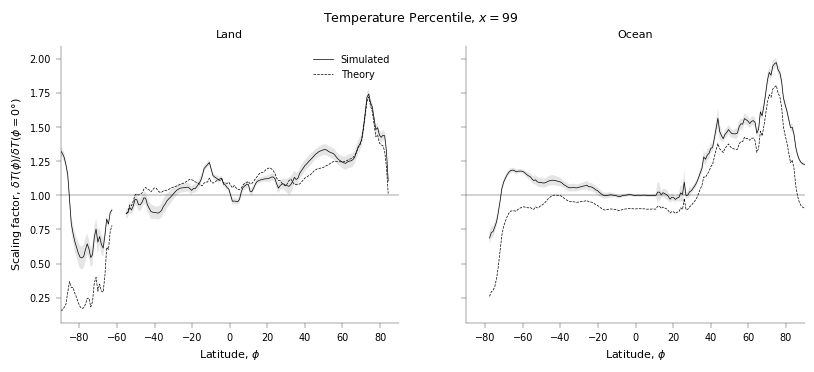

In [93]:
quant_plot_ind = -1

save_sf_theory_fig = False
fig, ax = plt.subplots(1,n_surf, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*n_surf)
for i in range(n_surf):
    ax[i].plot(ds[0].lat, sf_simulated[i, quant_plot_ind], color='k', label='Simulated')
    ax[i].plot(ds[0].lat, sf_theory['linear'][i, quant_plot_ind], color='k', linestyle='--', label='Theory')
    ax[i].fill_between(ds[0].lat, sf_simulated[i, quant_plot_ind] + sf_simulated_error[i, quant_plot_ind],
                       sf_simulated[i, quant_plot_ind] - sf_simulated_error[i, quant_plot_ind], fc='k', alpha=0.1)
    ax[i].axhline(1, color='k', lw=ax_linewidth)
    ax[i].set_xlabel('Latitude, $\phi$')
    ax[i].set_title(str(ds[0].surface[i].values).capitalize())
ax[0].set_ylabel(f'Scaling factor, $\delta T(\phi)/\delta T(\phi={lat_ref:.0f}\degree)$')
ax[0].legend()
ax[0].set_xlim(-90, 90)
fig.suptitle(f'Temperature Percentile, $x={ds[0].quant[quant_plot_ind]:.0f}$', fontsize=9)
plt.show()
if save_fig or save_sf_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/sf_theory_{ds[0].quant[quant_plot_ind]:.0f}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Breakdown into 4 change contributions
The theory can be split into 4 change ($\delta$) terms:

* $\delta \overline{T_s}$
* $\delta \overline{r_s}$
* $\delta \overline{\epsilon_s}$
* $\delta \Delta \chi(x)$ terms for $\chi = r, T_{FT}, \epsilon$

Here I plot the contribution of each of these (assuming the linear theory).

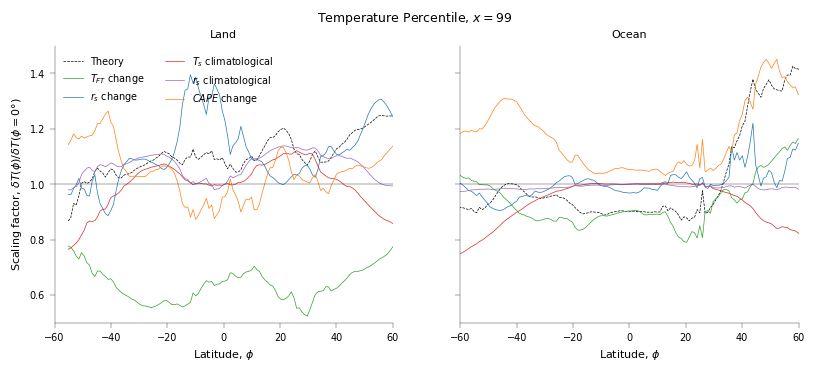

In [94]:
colors_cont = {'temp_ft_change': default_colors[2],
               'temp_anom': default_colors[3], 'r_anom': default_colors[4],
               'r_change': default_colors[0],
               'cape_change': default_colors[1]}
labels_cont = {'temp_ft_change': '$T_{FT}$ change', 'r_change': '$r_s$ change', 'cape_change': '$CAPE$ change',
               'temp_anom': '$T_s$ climatological', 'r_anom': '$r_s$ climatological'}

save_breakdown_change_fig = False
fig, ax = plt.subplots(1,n_surf, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*n_surf)
for i in range(n_surf):
    # ax[i].plot(lat, sf_simulated[i, q_plot_ind], color='k', label='Simulated')
    ax[i].plot(ds[0].lat, sf_theory['linear'][i, quant_plot_ind], color='k', linestyle='--', label='Theory')
    for key1 in sf_theory_breakdown:
        ax[i].plot(ds[0].lat, (0 if 'ft' in key1 else 1) + sf_theory_breakdown[key1][i, quant_plot_ind],
                   color=colors_cont[key1], label=labels_cont[key1])
    ax[i].axhline(1, color='k', lw=ax_linewidth)
    ax[i].set_xlabel('Latitude, $\phi$')
    ax[i].set_title(str(ds[0].surface.values[i]).capitalize())
ax[0].legend(ncol=2)
ax[0].set_ylabel(f'Scaling factor, $\delta T(\phi)/\delta T(\phi={lat_ref:.0f}\degree)$')
ax[0].set_xlim(-90, 90)
ax[0].set_xlim(-60, 60)
ax[0].set_ylim(0.5, 1.5)
fig.suptitle(f'Temperature Percentile, $x={ds[0].quant[quant_plot_ind]:.0f}$', fontsize=9)
plt.show()
if save_fig or save_breakdown_change_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/sf_breakdown_change_{ds[0].quant[quant_plot_ind]:.0f}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

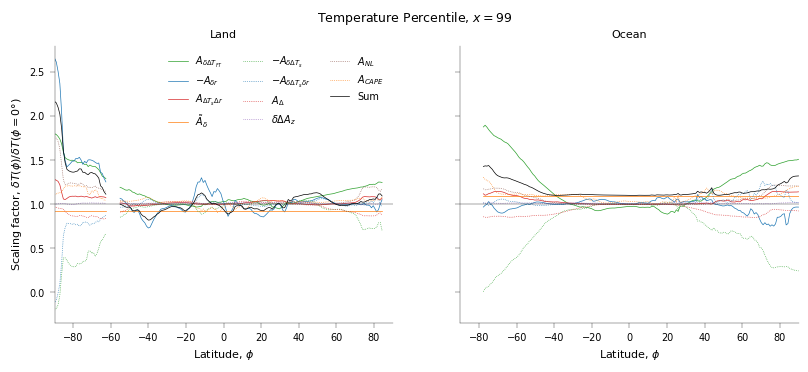

In [95]:
colors_approx = {'temp_ft_anom_change': default_colors[2], 'r_change': default_colors[0], 'anom_temp_s_r': default_colors[3],
                 'ref_change': default_colors[1],
                 'temp_s_anom_change': default_colors[2], 'temp_s_anom_r_change': default_colors[0], 'anom': default_colors[3],
                 'z_anom_change': default_colors[4], 'nl': default_colors[5], 'cape': default_colors[1]}
linestyles_approx = {'temp_ft_anom_change': None, 'r_change': None, 'anom_temp_s_r': None, 'ref_change': None,
                     'temp_s_anom_change': ':', 'temp_s_anom_r_change': ':', 'z_anom_change': ':', 'anom': ':', 'nl': ':', 'cape': ':'}
labels_approx = {'temp_ft_anom_change': '$A_{\delta \Delta T_{FT}}$', 'r_change': '$-A_{\delta r}$', 'anom_temp_s_r': '$A_{\Delta T_s \Delta r}$',
                 'ref_change': '$\\tilde{A}_{\delta}$', 'temp_s_anom_change': '$-A_{\delta \Delta T_s}$',
                 'temp_s_anom_r_change': '$-A_{\delta \Delta T_s \delta r}$', 'z_anom_change': '$\delta \Delta A_z$',
                 'anom': '$A_{\Delta}$', 'nl': '$A_{NL}$', 'cape': '$A_{CAPE}$'}
label_use = ['$A_{\delta \Delta T_{FT}}-A_{\delta r}+A_{\Delta T_s \Delta r}+\\tilde{A}_{\delta}$',
             '$A_{\delta \Delta T_s}+A_{\delta \Delta T_s \delta r}+A_{\Delta}+\\tilde{A}_{\delta}+\delta \Delta A_z+A_{NL}$']

fig, ax = plt.subplots(1,n_surf, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*n_surf)
for i in range(n_surf):
    for key in colors_approx:
        ax[i].plot(ds[0].lat, 1 + sf_theory_approx[key][i, quant_plot_ind],
                   color=colors_approx[key], label=labels_approx[key], linestyle=linestyles_approx[key])
    ax[i].plot(ds[0].lat, 1 + sum([sf_theory_approx[key][i, quant_plot_ind] for key in sf_theory_approx]),
               color='k', label='Sum')
    ax[i].axhline(1, color='k', lw=ax_linewidth)
    ax[i].set_xlabel('Latitude, $\phi$')
    ax[i].set_title(str(ds[0].surface.values[i]).capitalize())
ax[0].legend(ncol=3)
ax[0].set_xlim(-90, 90)
ax[0].set_ylabel(f'Scaling factor, $\delta T(\phi)/\delta T(\phi={lat_ref:.0f}\degree)$')
fig.suptitle(f'Temperature Percentile, $x={ds[0].quant[quant_plot_ind]:.0f}$', fontsize=9)
plt.show()
# isca_tools.savefig(fig)

### Variables
Below, I look at the variables in the reference (solid) and warmer (dotted) simulations. Clearly CAPE becomes negative at the high latitudes, so convection is not active.

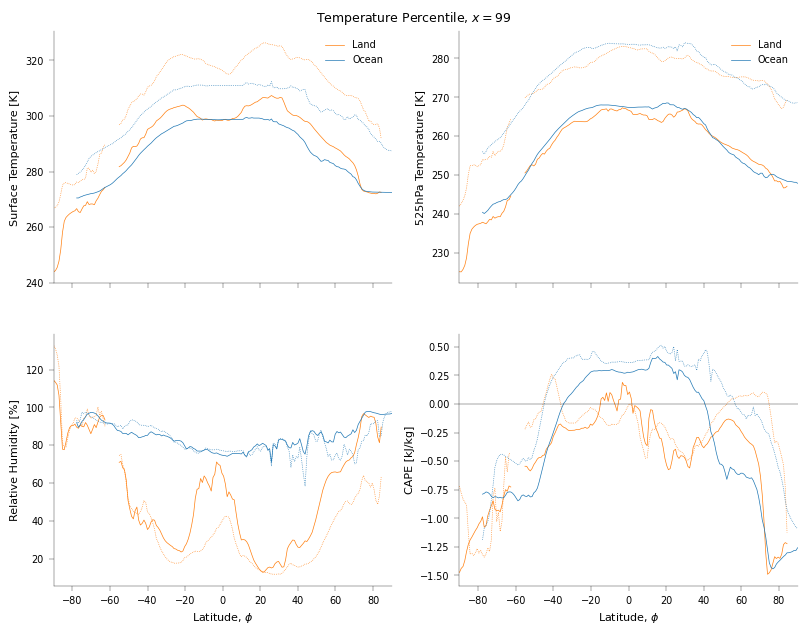

In [96]:
color_surf = [default_colors[1], default_colors[0]]
fig, ax = plt.subplots(2,2, sharex=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*n_surf)
ax = ax.flatten()
for i in range(n_surf):
    for j in range(n_exp):
        for k in range(ds[0].lev.size):
            ax[k].plot(ds[0].lat, ds[j].T.where(ds[j].is_surf).isel(surface=i, quant=quant_plot_ind, lev=k),
                       label=str(ds[0].surface[i].values).capitalize() if j == 0 else None,
                       color=color_surf[i], linestyle=['-', ':'][j])
        # ax[1].plot(ds[0].lat, ds['temp_ft'][i, quant_plot_ind, j], label=str(ds[0].surface[i].values).capitalize() if j == 0 else None,
        #            color=default_colors[1 - i], linestyle=['-', ':'][j])
        ax[2].plot(ds[0].lat, ds[j].rh.where(ds[j].is_surf).isel(surface=i, quant=quant_plot_ind) * 100,
                   color=color_surf[i], linestyle=['-', ':'][j])
        ax[3].plot(ds[0].lat, ds[j].cape_approx.where(ds[j].is_surf).isel(surface=i, quant=quant_plot_ind),
                   label=['Ref', 'Warm'][j] if i == 0 else None, color=color_surf[i], linestyle=['-', ':'][j])
ax[2].set_xlabel('Latitude, $\phi$')
ax[3].set_xlabel('Latitude, $\phi$')
ax[0].set_ylabel('Surface Temperature [K]')
ax[1].set_ylabel('{:.0f}hPa Temperature [K]'.format(pressure_ft/100))
ax[2].set_ylabel('Relative Humidity [%]')
ax[3].set_ylabel('CAPE [kJ/kg]')
ax[3].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_xlim(-90, 90)
# ax[0].set_xlim(-60, 60)
ax[0].legend()
ax[1].legend()
fig.suptitle(f'Temperature Percentile, $x={ds[0].quant[quant_plot_ind]:.0f}$', fontsize=9, y=0.91);
# plt.plot(lat, ds['mse_lapse'][1, q_plot_ind, 0])
# plt.plot(ds['mse_lapse'][1, q_plot_ind, 1])

### Distribution of locations used in quantile calculation
Here I look at what locations make up the calculations. The first plot clearly shows the lack of land in southern hemisphere, so the amount of data used in these calculations is very much smaller than in the NH.

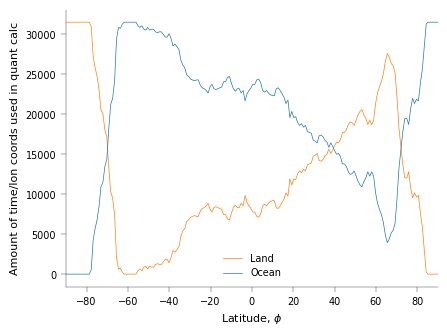

In [97]:
fig, ax = plt.subplots(1,1, sharex=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col'])
for i in range(n_surf):
    ax.plot(ds[0].lat, ds[0].use_in_calc.isel(surface=i, quant=-1).sum(dim='time').sum(dim='lon'),
            color=color_surf[i], label=str(ds[0].surface[i].values).capitalize())
ax.legend()
ax.set_xlim(-90, 90)
ax.set_xlabel('Latitude, $\phi$')
ax.set_ylabel('Amount of time/lon coords used in quant calc')
plt.show()

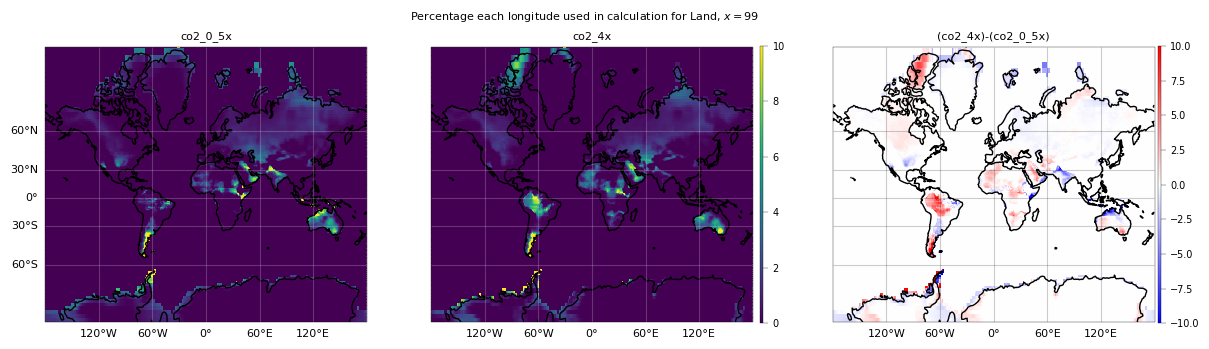

In [99]:
def get_calc_lon_frac(ds, surf_ind, quant_ind):
    return (ds.use_in_calc.isel(surface=surf_ind, quant=quant_ind).sum(dim='time')/
            ds.use_in_calc.isel(surface=surf_ind, quant=quant_ind).sum(dim='time').sum(dim='lon'))

surf_plot_ind = 0
quant_plot_ind = -1
fig, ax = plt.subplots(1, 3, subplot_kw={'projection': ccrs.Mercator()}, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, 3*im_sz*width['one_col'])
for i in range(n_exp):
    im = ax[i].pcolormesh(ds[0].lon, ds[0].lat, np.nan_to_num(get_calc_lon_frac(ds[i], surf_plot_ind, quant_plot_ind), nan=0)*100,
                          transform=ccrs.PlateCarree(), vmin=0, vmax=10)
    ax[i].coastlines()
    ax[i].set_title(exp_id[i])
cbar = fig.colorbar(im, ax=ax[:2].ravel().tolist(), orientation='vertical', aspect=100, pad=0.01, fraction=0.01)
im = ax[2].pcolormesh(ds[0].lon, ds[0].lat, np.nan_to_num(get_calc_lon_frac(ds[1], surf_plot_ind, quant_plot_ind) -
                                                          get_calc_lon_frac(ds[0], surf_plot_ind, quant_plot_ind), nan=0)*100,
                      transform=ccrs.PlateCarree(),
                      vmin=-10, vmax=10, cmap='bwr')
cbar = fig.colorbar(im, ax=ax[2:].ravel().tolist(), orientation='vertical', aspect=100, pad=0.01, fraction=0.01)
ax[2].coastlines()
ax[2].set_title(f'({exp_id[1]})-({exp_id[0]})')

# Add gridlines with labels
for i in range(len(ax)):
    gl = ax[i].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.2, color='w' if i<=1 else 'k')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = True if i==0 else None
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
fig.suptitle(f"Percentage each longitude used in calculation for {str(ds[0].surface[surf_plot_ind].values).capitalize()}, "
             f"$x={ds[0].quant[quant_plot_ind]:.0f}$", fontsize=8)
plt.show()